## Analysis of the Quasiparticle Method from an analytical perspective

####  one-body matrix n -> n

Imports

In [14]:

from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator
import numpy as np
import torch
from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.utils_quasiparticle_approximation import QuasiParticlesConverterOnlynnpp,HardcoreBosonsBasis,QuasiParticlesConverterWithPhase
from scipy.sparse import lil_matrix
file_name='data/gxpf1a'

SPS=SingleParticleState(file_name=file_name)

nparticles_a=2
nparticles_b=0

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{18}$O'

NSM Hamiltonian

In [15]:

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/gxpf1a_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)
print(NSMHamiltonian.basis)
print(NSMHamiltonian.hamiltonian)
print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))

size= 40 20
[-19.73367578]
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 844 stored elements and shape (30, 30)>
  Coords	Values
  (0, 0)	-18.371668181818183
  (0, 1)	0.6098090909090912
  (0, 2)	0.0020714109743524946
  (0, 3)	-0.2980136363636365
  (0, 4)	-0.23367732254077234
  (0, 5)	0.17732298743377128
  (0, 6)	0.20700909090909111
  (0, 7)	0.17339206938505103
  (0, 8)	-0.05751470626864255
  (0, 9)	0.05911517264090189
  (0, 10)	-0.17339206938505086
  (0, 11)	-0.05751470626864258
  (0, 12)	0.05911517264090189
  (0, 13)	0.23367732254077245
  (0, 14)	0.17732298743377126
  (0, 15)	0.0020714109743524833
  (0, 16)	-0.36278567700730024
  (0, 17)	0.10995791965874382
  (0, 18)	0.14449272781592892
  (0, 19)	0.02286089097431262
  (0, 20)	0.019820265302630702
  (0, 21)	0.022860890974312605
  (0, 22)	0.019820265302630702
  (0, 23)	0.10995791965874382
  (0, 24)	-0.5

Quasiparticle Basis

In [16]:
QPC=QuasiParticlesConverterOnlynnpp()

QPC.initialize_shell(state_encoding=SPS.state_encoding)


#just for the basis
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)

print(QPC.particles2quasiparticles.shape)
print(QPC.quasiparticle_basis)


(10, 30)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Get the effective Hamiltonian

In [17]:

hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rr=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_qr=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_rq=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T




Build $H_{qq}$ using qubits

In [19]:
QubitBasis=HardcoreBosonsBasis(basis=QPC.quasiparticle_basis)

h_qq=0.
for i in range(len(QPC.couples)//2): #just n-n 
    for j in range(len(QPC.couples)//2):
        
        h_qq+=hamiltonian_qq[i,j]*QubitBasis.adag_a_matrix(i,j)
        

print(QPC.quasiparticle_basis)


one_body_nn={}
for i,b in enumerate(QPC.quasiparticle_basis):
    for j,d in enumerate(QPC.quasiparticle_basis):
        print(b)
        idx_b=np.nonzero(b)[0]
        idx_d=np.nonzero(d)[0]
        print(idx_b)
        print(idx_d)

        one_body_nn[(idx_b[0],idx_d[0])]=hamiltonian_qq[i,j]
        
print(one_body_nn)

keys=np.asarray(list(one_body_nn.keys()))
values=np.asarray(list(one_body_nn.values()))
np.savez('data/matrix_elements_h_eff_2body/one_body_nn_pf',keys=keys,values=values)

print(keys)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0]
[0]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0]
[1]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0]
[2]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0]
[3]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0]
[4]
[1. 0. 0. 0. 0. 0. 

In [6]:
print(one_body_nn[(2,2)])

-17.740837012987015


#### n-n -> n-n quasiparticle interaction

In [9]:
file_name='data/gxpf1a'

SPS=SingleParticleState(file_name=file_name)

nparticles_a=4
nparticles_b=0

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{20}$O'

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/gxpf1a_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))

size= 40 20
[-38.74112048]
total_m= [1.3886597e-16]


Pairing Hamiltonian one-body term

In [10]:
QPC=QuasiParticlesConverterOnlynnpp()

QPC.initialize_shell(state_encoding=SPS.state_encoding)


#just for the basis
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)



##### Two-body correction

In [12]:

hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rr=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_qr=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_rq=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T


#print(twobody_qr)

QubitBasis=HardcoreBosonsBasis(basis=QPC.quasiparticle_basis)
h_qq=0.
for key,value in one_body_nn.items():
    idx_a,idx_b=key

    h_qq+=value*QubitBasis.adag_a_matrix(idx_a,idx_b)

#### twobody terms
twobody_nn={}
for i,b in enumerate(QPC.quasiparticle_basis):
    for j,d in enumerate(QPC.quasiparticle_basis):
        idx_a,idx_b=np.nonzero(b)[0]
        idx_c,idx_d=np.nonzero(d)[0]
        if hamiltonian_qq[i,j]-h_qq[i,j]!=0.:
            twobody_nn[(idx_a,idx_b,idx_c,idx_d)]=hamiltonian_qq[i,j]-h_qq[i,j]
            
print('twobody=',twobody_nn)
 

h_qq=0.

for key,value in one_body_nn.items():
    idx_a,idx_b=key

    h_qq+=value*QubitBasis.adag_a_matrix(idx_a,idx_b)



for key,value in twobody_nn.items():
    idx_a,idx_b,idx_c,idx_d=key

    h_qq+=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)

value,_=eigsh(h_qq,k=1)
print(h_qq)
print(value)

keys=np.asarray(list(twobody_nn.keys()))
values=np.asarray(list(twobody_nn.values()))
np.savez('data/matrix_elements_h_eff_2body/twobody_nn_pf',keys=keys,values=values)

twobody= {(np.int64(0), np.int64(1), np.int64(0), np.int64(1)): np.float64(-0.4711181818181771), (np.int64(0), np.int64(2), np.int64(0), np.int64(2)): np.float64(0.15247272727272332), (np.int64(0), np.int64(3), np.int64(0), np.int64(3)): np.float64(0.3344818181818212), (np.int64(0), np.int64(4), np.int64(0), np.int64(4)): np.float64(0.5034266666666696), (np.int64(0), np.int64(5), np.int64(0), np.int64(5)): np.float64(0.3225233333333364), (np.int64(0), np.int64(6), np.int64(0), np.int64(6)): np.float64(-1.8432318181818133), (np.int64(0), np.int64(7), np.int64(0), np.int64(7)): np.float64(0.7631954545454569), (np.int64(0), np.int64(8), np.int64(0), np.int64(8)): np.float64(1.7905113636363659), (np.int64(0), np.int64(9), np.int64(0), np.int64(9)): np.float64(0.5496999999999979), (np.int64(1), np.int64(2), np.int64(1), np.int64(2)): np.float64(-0.5265207792207818), (np.int64(1), np.int64(3), np.int64(1), np.int64(3)): np.float64(-0.05553766233766311), (np.int64(1), np.int64(4), np.int64(1)

Correction for the (n-n)--(p-p) interaction

In [253]:




tot_hamiltonian=hamiltonian_qq
values,psi=eigsh(hamiltonian_qq,k=1)
e=values[0]
approximations=[]
nsteps_iteration=30
single_term = hamiltonian_rq  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        single_term = hamiltonian_rr @ single_term  # Efficient update
    approximations.append(hamiltonian_qr @ single_term)  # Store result





 
history_errors_exact=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian=0.
    for j in range(i):
        delta_hamiltonian=delta_hamiltonian+approximations[j]/e**(j+1)
    values,psi=eigsh(hamiltonian_qq+delta_hamiltonian,k=1)
    e=values[0]
    print(e)
    print(np.abs((e-egs[0])/egs[0]),'index=',i)
    history_errors_exact.append(np.abs((e-egs[0])/egs[0]))

100%|██████████| 30/30 [00:00<00:00, 293.05it/s]

-38.61616152871011
0.003225486168301657 index= 0
-38.645281663063706
0.0024738265881168024 index= 1
-38.66727647874572
0.0019060883448437811 index= 2
-38.68399224889506
0.0014746147595796788 index= 3
-38.69676549603999
0.0011449070230022988 index= 4
-38.70657289843766
0.0008917547579946099 index= 5
-38.71413468412788
0.0006965671744369109 index= 6
-38.71998645852112
0.00054551902917937 index= 7
-38.724529573070264
0.0004282504914289931 index= 8
-38.728066818517775
0.00033694581557132966 index= 9
-38.73082799197082
0.0002656733944577512 index= 10
-38.732988402942304
0.0002099080746919081 index= 11
-38.73468240055075
0.00016618198758876307 index= 12
-38.736013350890694
0.00013182700963367225 index= 13
-38.737061056320634
0.00010478325310207386 index= 14
-38.73788731285468
8.345561663015332e-05 index= 15
-38.73854009986201
6.660563915689027e-05 index= 16
-38.7390567566729
5.326950420431186e-05 index= 17
-38.739466403090525
4.269556074114941e-05 index= 18
-38.73979179181572
3.4296507714586

In [254]:
print(delta_hamiltonian)

  (np.int32(0), np.int32(32))	-0.0012026841988999179
  (np.int32(0), np.int32(43))	-0.0007302706939420422
  (np.int32(0), np.int32(44))	-0.0008055971606111641
  (np.int32(0), np.int32(42))	0.0007892253307189938
  (np.int32(0), np.int32(39))	-0.0032704604749630817
  (np.int32(0), np.int32(34))	0.00016168883088062786
  (np.int32(0), np.int32(33))	0.0011662601094337788
  (np.int32(0), np.int32(38))	0.0003572684832038919
  (np.int32(0), np.int32(37))	-0.0004535134512848305
  (np.int32(0), np.int32(36))	0.0012372923624063613
  (np.int32(0), np.int32(30))	-0.0052748254819858075
  (np.int32(0), np.int32(31))	0.0050360862169566865
  (np.int32(0), np.int32(23))	0.001533633058182093
  (np.int32(0), np.int32(22))	0.0013493950649064983
  (np.int32(0), np.int32(19))	-0.0002900131749315039
  (np.int32(0), np.int32(16))	0.002256523087609477
  (np.int32(0), np.int32(15))	-0.01874985658263215
  (np.int32(0), np.int32(12))	-0.035586455161146946
  (np.int32(0), np.int32(29))	-0.00692619021396452
  (np.in

In [255]:

twobody_term_corrections_nn={}
#twobody_term_corrections_pp={}

for i,b in enumerate(QPC.quasiparticle_basis):
    for j,d in enumerate(QPC.quasiparticle_basis):
        idx_a,idx_b=np.nonzero(b)[0]
        idx_c,idx_d=np.nonzero(d)[0]

        twobody_term_corrections_nn[(idx_a,idx_b,idx_c,idx_d)]=delta_hamiltonian[i,j]#-external_potential_qq[i,j]
        #twobody_term_corrections_pp[(idx_a+len(QPC.couples)//2,idx_b+len(QPC.couples)//2,idx_c+len(QPC.couples)//2,idx_d+len(QPC.couples)//2)]=delta_hamiltonian[i,j]


print(twobody_term_corrections_nn)

{(np.int64(0), np.int64(1), np.int64(0), np.int64(1)): np.float64(-0.1749429683207264), (np.int64(0), np.int64(1), np.int64(0), np.int64(2)): np.float64(-0.02762559598062028), (np.int64(0), np.int64(1), np.int64(0), np.int64(3)): np.float64(-0.04477420728727905), (np.int64(0), np.int64(1), np.int64(0), np.int64(4)): np.float64(-0.028625578843201164), (np.int64(0), np.int64(1), np.int64(0), np.int64(5)): np.float64(-0.012259869139021789), (np.int64(0), np.int64(1), np.int64(0), np.int64(6)): np.float64(0.06099813445983434), (np.int64(0), np.int64(1), np.int64(0), np.int64(7)): np.float64(-0.017957854995442796), (np.int64(0), np.int64(1), np.int64(0), np.int64(8)): np.float64(-0.029459658426005047), (np.int64(0), np.int64(1), np.int64(0), np.int64(9)): np.float64(-0.0007136486558049966), (np.int64(0), np.int64(1), np.int64(1), np.int64(2)): np.float64(0.03255279952021803), (np.int64(0), np.int64(1), np.int64(1), np.int64(3)): np.float64(-0.07150791931333789), (np.int64(0), np.int64(1), n

#### The $^{24}$ Mg case

In [269]:

print(file_name)
SPS=SingleParticleState(file_name=file_name)

nparticles_a=10
nparticles_b=0

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{46}$Ca'

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/gxpf1a_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis)) 
        
        
        



data/gxpf1a
size= 40 20
[-85.35155886]
total_m= [-5.1803766e-17]


#### Get the mean Field coefficients

In [37]:
one_particle_density=np.zeros(size_a+size_b)
for i in range(size_a+size_b):
    one_particle_density[i]=psi0.conjugate().T.dot(NSMHamiltonian.adag_a_matrix(i,i).dot(psi0))

KeyboardInterrupt: 

In [24]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 24/24 [01:11<00:00,  2.97s/it]


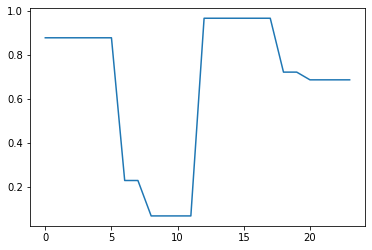

15.999999999999988


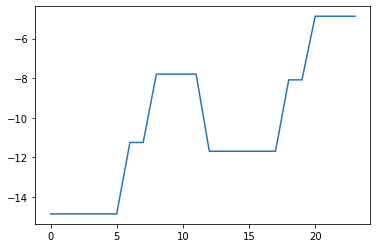

-178.63965857589278


In [165]:
plt.plot(one_particle_density)
plt.show()
print(np.sum(one_particle_density))

energy_values_meanfield=np.zeros((size_a+size_b))
for a in range(size_a+size_b):
    energy_values_meanfield[a]=SPS.energies[a]
    for b in range(size_a+size_b):
        if (a,b,a,b) in twobody_matrix.keys():
            energy_values_meanfield[a]+=twobody_matrix[(a,b,a,b)]*one_particle_density[b]/2

plt.plot(energy_values_meanfield)
plt.show()
        
print(np.sum(energy_values_meanfield*one_particle_density))


In [166]:
MeanFieldHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
MeanFieldHamiltonian.get_external_potential(external_potential=energy_values_meanfield)
#MeanFieldHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a-2}_{nparticles_b-2}.npz')
MeanFieldHamiltonian.get_hamiltonian()

egs,psi0=MeanFieldHamiltonian.get_spectrum(n_states=1)

print(egs)
print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=MeanFieldHamiltonian.basis)) 

size= 24 12
[-185.31551383]
total_m= [1.4012557e-45]


In [167]:
print(energy_values_meanfield)

[-14.87012213 -14.87012213 -14.87012213 -14.87012213 -14.87012213
 -14.87012213 -11.25356287 -11.25356287  -7.79600063  -7.79600063
  -7.79600063  -7.79600063 -11.69847079 -11.69847079 -11.69847079
 -11.69847079 -11.69847079 -11.69847079  -8.08563548  -8.08563548
  -4.86634268  -4.86634268  -4.86634268  -4.86634268]


In [168]:
print(MeanFieldHamiltonian.hamiltonian)
print(MeanFieldHamiltonian.basis[0])

  (0, 0)	-185.31551383374617
  (1, 1)	-185.31551383374617
  (2, 2)	-182.09622103362238
  (3, 3)	-182.09622103362238
  (4, 4)	-178.8769282334986
  (5, 5)	-178.48338572577288
  (6, 6)	-178.48338572577285
  (7, 7)	-175.26409292564907
  (8, 8)	-178.48338572577285
  (9, 9)	-175.26409292564907
  (10, 10)	-171.65125761779953
  (11, 11)	-178.48338572577285
  (12, 12)	-171.65125761779956
  (13, 13)	-171.6512576177996
  (14, 14)	-174.8668264733636
  (15, 15)	-174.8668264733636
  (16, 16)	-171.64753367323982
  (17, 17)	-168.03469836539028
  (18, 18)	-181.6989545813369
  (19, 19)	-178.4796617812131
  (20, 20)	-174.8668264733636
  (21, 21)	-174.8668264733636
  (22, 22)	-171.64753367323982
  (23, 23)	-168.03469836539028
  (24, 24)	-174.8668264733636
  :	:
  (7537, 7537)	-146.57034049961254
  (7538, 7538)	-143.35104769948876
  (7539, 7539)	-146.57034049961254
  (7540, 7540)	-143.35104769948876
  (7541, 7541)	-146.57034049961254
  (7542, 7542)	-139.73821239163925
  (7543, 7543)	-139.73821239163925
  (

#### Effective H_rr

In [169]:
from itertools import combinations
# you have to conserve the m valueeeee
def find_lowest_energy_subset(energy_values, m_values, sorted_indices):
    for size in range(2, len(sorted_indices) + 1, 2):  # Only even sizes (to make sum=0 possible)
        for subset in combinations(sorted_indices, size):  # Iterate over all subsets
            if np.sum(m_values[list(subset)]) == 0:  # Check if sum(m) == 0
                return np.array(subset)  # Return the first valid subset
    return np.array([])  # Return empty if no subset found

m_values=np.array([-5/2,-3/2,-1/2,1/2,3/2,5/2,-1/2,1/2,-3/2,-1/2,1/2,3/2,-5/2,-3/2,-1/2,1/2,3/2,5/2,-1/2,1/2,-3/2,-1/2,1/2,3/2])


mean_field_hamiltonian_rr=lil_matrix((rest_basis_ne20.shape[0],rest_basis_ne20.shape[0]))
basis_restricted=np.zeros_like(rest_basis_ne20)
elements=[]

for i,basis in enumerate(rest_basis_ne20):
    
    a,b,c,d=np.nonzero(basis)[0]


    comb_neutrons=combinations(QPC.couples[:size_a//2],(nparticles_a-2)//2)
    comb_protons=combinations(QPC.couples[size_a//2:],(nparticles_b-2)//2)
    
    
    min=0
    for set_neutron_couples in comb_neutrons:
        
        neutron_sets=[]
        for couple in set_neutron_couples:

            x,y=couple
            neutron_sets.append(x)
            neutron_sets.append(y)
        
        if a in neutron_sets or b in neutron_sets:
            continue

        for set_proton_couples in comb_protons:
            
            
            
            proton_sets=[]
            for couple in set_proton_couples:
                x,y=couple
                proton_sets.append(x)
                proton_sets.append(y)

            if c in proton_sets or d in proton_sets:
                continue
            

               

            
            if np.sum(m_values[[(proton_sets)]])+np.sum(m_values[[a,b,c,d]])+np.sum(m_values[[(neutron_sets)]])==0. :
                e_neutron=np.sum(energy_values_meanfield[[neutron_sets]])
                e_proton=np.sum(energy_values_meanfield[[proton_sets]])
                
                e_total=e_neutron+e_proton
                if e_total < min:
                    new_base=np.zeros((size_a+size_b))
                    min=e_total
                    if len(proton_sets)!=0:
                        new_base[[proton_sets]]=1
                    if len(neutron_sets)!=0:
                        new_base[[neutron_sets]]=1
                    new_base[[a,b,c,d]]=1
            else:
                continue
                    
    if min!=0:
        basis_restricted[i]=(new_base)

    

    

    energy_included=np.sum(energy_values_meanfield[[a,b]])+np.sum(energy_values_meanfield[[c,d]]) 
    energy_excluded= min

    if min!=0.:
        mean_field_hamiltonian_rr[i,i]=energy_excluded+energy_included



# dressed_qr_hamiltonian=lil_matrix((hamiltonian_ne20_qq.shape[0],rest_basis_ne20.shape[0]))
# qr_correction_dictionary=qr_correction.tocoo()
# for q,r,value in zip(qr_correction_dictionary.row,qr_correction_dictionary.col,qr_correction_dictionary.data):
#     basis=rest_basis_ne20[r]
#     i,j,k,l=np.nonzero(basis)[0]
#     min_values_sorted=np.sort(np.setdiff1d(energy_values_meanfield,[i,j,k,l]))
#     energy_excluded= np.sum(min_values_sorted[:4])
#     dressed_qr_hamiltonian[q,r]=qr_correction[q,r]+energy_excluded

# dressed_rq_hamiltonian=lil_matrix((rest_basis_ne20.shape[0],hamiltonian_ne20_qq.shape[0]))
# rq_correction_dictionary=rq_correction.tocoo()
# for r,q,value in zip(rq_correction_dictionary.row,rq_correction_dictionary.col,rq_correction_dictionary.data):
#     basis=rest_basis_ne20[r]
#     i,j,k,l=np.nonzero(basis)[0]
#     min_values_sorted=np.sort(np.setdiff1d(energy_values_meanfield,[i,j,k,l]))
#     energy_excluded= np.sum(min_values_sorted[:4])
#     dressed_rq_hamiltonian[r,q]=rq_correction[r,q]+energy_excluded    
    




/tmp/ipykernel_577035/1729250186.py:56: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(m_values[[(proton_sets)]])+np.sum(m_values[[a,b,c,d]])+np.sum(m_values[[(neutron_sets)]])==0. :
/tmp/ipykernel_577035/1729250186.py:57: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  e_neutron=np.sum(energy_values_meanfield[[neutron_sets]])
/tmp/ipykernel_577035/1729250186.py:58: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpret

We need to correct the H_rq and H_qr

In [170]:
print(mean_field_hamiltonian_rr)

  (0, 0)	-164.41813911298098
  (1, 1)	-171.2502672209543
  (2, 2)	-164.41813911298098
  (3, 3)	-171.25026722095427
  (4, 4)	-168.0309744208305
  (5, 5)	-171.25026722095424
  (6, 6)	-164.41813911298098
  (7, 7)	-164.41813911298095
  (8, 8)	-171.25026722095424
  (9, 9)	-168.0309744208305
  (10, 10)	-171.25026722095427
  (11, 11)	-168.0309744208305
  (12, 12)	-171.25026722095424
  (13, 13)	-174.8631025288038
  (14, 14)	-178.08239532892756
  (15, 15)	-164.418139112981
  (16, 16)	-164.41813911298098
  (17, 17)	-171.25026722095427
  (18, 18)	-168.0309744208305
  (19, 19)	-171.25026722095427
  (20, 20)	-168.0309744208305
  (21, 21)	-171.2502672209543
  (22, 22)	-171.2502672209543
  (23, 23)	-174.86310252880384
  (24, 24)	-174.8631025288038
  (25, 25)	-178.0823953289276
  (26, 26)	-178.48338572577285
  (27, 27)	-175.26409292564904
  (28, 28)	-178.48338572577282
  (29, 29)	-175.26409292564904
  (30, 30)	-178.48338572577282
  (31, 31)	-178.48338572577285
  (32, 32)	-182.09622103362236
  (33, 33)

In [25]:
QPC=QuasiParticlesConverterOnlynnpp()

QPC.initialize_shell(state_encoding=SPS.state_encoding)


#just for the basis
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)



In [172]:
#print(mean_field_hamiltonian_rr)


converted_quasiparticle_basis=np.zeros((QPC.quasiparticle_basis.shape[0],2*QPC.quasiparticle_basis.shape[1]))
for i,b in enumerate(QPC.quasiparticle_basis):
    index=np.nonzero(b)[0]
    new_base=np.zeros(2*QPC.quasiparticle_basis.shape[1])
    for idxs in index:
        new_base[QPC.couples[idxs]]=1
    converted_quasiparticle_basis[i]=new_base


In [173]:
dictionary_qr_correction=qr_correction.tocoo()
dictionary_qr_correction = {(row, col): value for row, col, value in zip(dictionary_qr_correction.row, dictionary_qr_correction.col, dictionary_qr_correction.data)}
print(QPC.couples)
effective_qr=lil_matrix((qr_correction.shape[0],qr_correction.shape[1]))
print(qr_correction.shape)
counter={}
for b in converted_quasiparticle_basis:
    counter[tuple(b)]=0.
print(counter)

for key,value in dictionary_qr_correction.items():
    a,i=key

        #print('keys=',key)
        
    x,y,z,w=np.nonzero(rest_basis_ne20[i])[0]
    new_item=basis_restricted[i].copy()

    new_item[[x,y,z,w]]=0.

    
    quasiparticle_indices=np.nonzero(quasiparticle_basis_ne20[a])[0]

    # for index in quasiparticle_indices:
    #     #print('couples=',QPC.couples[index])
    #     new_item[QPC.couples[index]]+=1
    #     print(np.sum(new_item),np.nonzero(new_item)[0],'with couple',QPC.couples[index])
    # # print('new indices=',new_item,'\n')
    # # print('sum=',np.sum(new_item))
    # if tuple(new_item) in counter.keys():
    #     # print('MARIO')
    #     # print(np.nonzero(new_item)[0],'\n')
        
    #     print(converted_quasiparticle_basis[a],'\n')
    #     print(basis_restricted[i],'\n')
    #     #if counter[tuple(new_item)]<=1:
    #     effective_qr[a,i]=value
    #     counter[tuple(new_item)]+=1
    # #print(new_item,converted_quasiparticle_basis[a])
    # else:
    #     print(key,'is not accepted \n')
            
    effective_qr[a,i]=value


# dictionary_rq_correction=rq_correction.tocoo()
# dictionary_rq_correction = {(row, col): value for row, col, value in zip(dictionary_rq_correction.row, dictionary_rq_correction.col, dictionary_rq_correction.data)}
# print(QPC.couples)
# effective_rq=lil_matrix((rq_correction.shape[0],rq_correction.shape[1]))
# for key,value in dictionary_rq_correction.items():
#     i,a=key
#     x,y,z,w=np.nonzero(rest_basis_ne20[i])[0]
#     new_item=basis_restricted[i].copy()
#     new_item[[x,y,z,w]]=0.
    
#     quasiparticle_indices=np.nonzero(quasiparticle_basis_ne20[a])[0]
#     for index in quasiparticle_indices:

#         new_item[QPC.couples[index]]+=1
#     if new_item in converted_quasiparticle_basis:
#         # print('MARIO')
#         # print(np.nonzero(new_item)[0],'\n')
#         effective_rq[i,a]=value
#     #print(new_item,converted_quasiparticle_basis[a])
#     else:
#         print(key,'is not accepted \n')  

    

[[0, 5], [1, 4], [2, 3], [6, 7], [8, 11], [9, 10], [12, 17], [13, 16], [14, 15], [18, 19], [20, 23], [21, 22]]
(36, 604)
{(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0): 0.0, (1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 

In [174]:
print(counter)
print(np.sum(list(counter.values())))

{(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0): 0.0, (1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0): 0.0, (1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0,

In [175]:
count_connections=0
for a in range(qr_correction.shape[0]):
    for i in range(qr_correction.shape[1]):
        if a==1 and qr_correction[a,i]!=0.:
            count_connections+=1

In [176]:
print(count_connections)
print(hamiltonian_qr)
print(hamiltonian_qr.shape)

for i in range(7):
    print(QPC.quasiparticle_basis[0])
    print(QPC.quasiparticle_basis[i],'\n')

60
  (0, 0)	-1.1102230246251565e-16
  (0, 1)	-1.27675647831893e-15
  (0, 2)	-1.8318679906315083e-15
  (0, 3)	-0.7108614512386662
  (0, 4)	0.977133826556014
  (0, 5)	1.609823385706477e-15
  (0, 6)	4.718447854656915e-16
  (0, 7)	0.5298448425179364
  (0, 8)	-0.7283125530979124
  (0, 9)	0.23695381707955535
  (0, 10)	0.410416050229172
  (0, 11)	-0.6514225510373428
  (0, 12)	-0.3869439629664616
  (0, 13)	-0.3869439629664616
  (0, 19)	4.85722573273506e-16
  (0, 20)	-0.3746568811211513
  (0, 21)	-0.6489247535071269
  (0, 22)	1.0299894902376425
  (0, 23)	0.09673599074161547
  (0, 24)	0.09673599074161547
  (0, 26)	0.410416050229172
  (0, 27)	0.23695381707955537
  (0, 28)	-0.6514225510373428
  (0, 38)	-0.7108614512386662
  (0, 39)	0.977133826556014
  :	:
  (399, 93270)	0.977133826556014
  (399, 93271)	0.7108614512386662
  (399, 93281)	-0.6514225510373428
  (399, 93282)	-0.23695381707955537
  (399, 93283)	-0.410416050229172
  (399, 93285)	-0.09673599074161547
  (399, 93286)	-0.09673599074161547
  

In [177]:
print(qr_correction)

  (0, 0)	-0.45876507936507965
  (0, 1)	1.096283198521862
  (0, 2)	0.11816984126984101
  (0, 4)	-0.027423351397426327
  (0, 5)	-0.44278468996383347
  (0, 6)	-0.2881301587301583
  (0, 11)	0.4808606694347589
  (0, 12)	0.6322793396075583
  (0, 15)	0.23103492063492015
  (0, 22)	-0.8929983991364584
  (0, 26)	0.20328479938540367
  (0, 27)	-0.5082840208321852
  (0, 28)	0.1894946496437248
  (0, 29)	0.5082840208321852
  (0, 30)	0.18949464964372487
  (0, 31)	0.20328479938540364
  (0, 32)	0.483679953708077
  (0, 33)	0.483679953708077
  (0, 34)	0.027423351397426327
  (0, 36)	-0.2245657281313674
  (0, 37)	0.23371242231056472
  (0, 38)	-0.4808606694347589
  (0, 43)	0.6762161618582865
  (0, 44)	0.2499675313975125
  (0, 47)	1.0962831985218615
  :	:
  (35, 534)	-0.11179270703329697
  (35, 536)	0.3837438166376979
  (35, 538)	-0.32893247559339583
  (35, 552)	-0.4744024744405058
  (35, 554)	0.21613933262539406
  (35, 556)	-0.64662
  (35, 561)	0.5061955498269921
  (35, 563)	-0.2414661373377319
  (35, 566)	-

In [178]:
print(effective_qr.shape,QPC.quasiparticle_basis.shape[0])
for i in range(quasiparticle_basis_ne20.shape[0]):
    for j in range(quasiparticle_basis_ne20.shape[0]):
        print((effective_qr @ effective_qr.T)[i,j],i,j)

(36, 604) 120
22.250253882563612 0 0
-5.025788110465884 0 1
3.8834760421294137 0 2
5.505936580591535 0 3
14.059724361739434 0 4
-4.093170625774788 0 5
-5.025788110465886 0 6
0.527685065195263 0 7
0.0 0 8
0.0 0 9
-3.9985659844432035 0 10
0.0 0 11
3.8834760421294128 0 12
0.0 0 13
0.19396619951121147 0 14
0.46395804722222245 0 15
0.0 0 16
-1.1916708899218762 0 17
5.505936580591536 0 18
0.0 0 19
0.46395804722222245 0 20
1.015396127619047 0 21
0.0 0 22
-0.23421052619047628 0 23
14.05972436173943 0 24
-3.998565984443199 0 25
0.0 0 26
0.0 0 27
6.075247869208319 0 28
0.0 0 29
-4.093170625774788 0 30
0.0 0 31
-1.1916708899218755 0 32
-0.23421052619047628 0 33
0.0 0 34
0.3830202240456472 0 35
-5.025788110465884 1 0
26.041858506780386 1 1
-1.3538070115793654 1 2
-1.2545371078034688 1 3
-7.754701850430439 1 4
-0.05724458350705776 1 5
8.898971797188217 1 6
-1.239488045165389 1 7
0.010431571882086333 1 8
0.7399263469095827 1 9
0.0 1 10
-0.023355460225575105 1 11
0.0 1 12
0.7131681897491131 1 13
-0.1

In [ ]:
# for i in range(quasiparticle_basis_ne20.shape[0]):
#     for j in range(quasiparticle_basis_ne20.shape[0]):
#         print((qr_correction @ rq_correction)[i,j],i,j)
print(hamiltonian_qr.shape)
for i in range(QPC.quasiparticle_basis.shape[0]):
    for j in range(QPC.quasiparticle_basis.shape[0]):
        print((hamiltonian_qr @ hamiltonian_rq)[i,j],i,j)

(400, 93310)
62.06484601000005 0 0
4.82602374704741 0 1
4.61050982079444 0 2
-6.388547386431676 0 3
-4.826023747047411 0 4
-4.826058422308022 0 5
5.270567813717329 0 6
-1.122942228571428 0 7
0.18715703809523793 0 8
2.758283709999996 0 9
4.826023747047409 0 10
6.881531373496555 0 11
-4.6589844164500125 0 12
0.5614711142857144 0 13
-0.748628152380952 0 14
-1.06087835 0 15
-0.28073555714285714 0 16
1.0293637095238095 0 17
2.121756699999999 0 18
0.0 0 19
4.826023747047408 0 20
0.9664389801904756 0 21
0.00014268342857142827 0 22


-0.14978376076190475 0 23
-0.13055239314285727 0 24
-0.2846362766542761 0 25
0.08048905391715225 0 26
0.0 0 27
0.0 0 28
0.0 0 29
0.0 0 30
0.1403677785714287 0 31
0.0 0 32
0.0 0 33
0.0 0 34
0.0 0 35
0.0 0 36
0.0 0 37
0.0 0 38
0.0 0 39
4.610509820794438 0 40
0.00014268342857142827 0 41
0.5518312629848141 0 42
-0.07222982628231656 0 43
-0.27708849706000926 0 44
0.0 0 45
1.9490531071304897 0 46
0.0 0 47
0.0 0 48
0.0 0 49
0.1403677785714287 0 50
0.7725070222222236 0 51
-1.6285972912312883 0 52
0.0 0 53
0.0 0 54
0.0 0 55
0.0 0 56
0.0 0 57
0.0 0 58
0.0 0 59
-6.388547386431673 0 60
-0.14978376076190475 0 61
-0.07222982628231657 0 62
5.571201820323564 0 63
0.08803683351141911 0 64
0.12326083999422874 0 65
-0.898127069780044 0 66
0.0 0 67
0.0 0 68
0.0 0 69
0.0 0 70
-0.06060241710204644 0 71
0.0 0 72
0.0 0 73
0.0 0 74
0.0 0 75
0.0 0 76
0.0 0 77
0.0 0 78
0.0 0 79
-4.82602374704741 0 80
-0.1305523931428572 0 81
-0.27708849706000926 0 82
0.08803683351141912 0 83
0.8848437344761901 0 84
0.0 0 85
-0.0

In [180]:
print(hamiltonian_qr)
count_connections=0
for a in range(hamiltonian_qr.shape[0]):
    for i in range(hamiltonian_qr.shape[1]):
        if a==6 and hamiltonian_qr[a,i]!=0.:
            count_connections+=1
            
# count_connections=0
# for i in range(hamiltonian_qr.shape[1]):
#     if hamiltonian_qr[0,i]!=0. and hamiltonian_qr[1,i]!=0.:
#         count_connections+=1

# count_connections=0
# for i in range(qr_correction.shape[1]):
#     if qr_correction[0,i]!=0. and qr_correction[1,i]!=0.:
#         count_connections+=1



  (0, 0)	-1.1102230246251565e-16
  (0, 1)	-1.27675647831893e-15
  (0, 2)	-1.8318679906315083e-15
  (0, 3)	-0.7108614512386662
  (0, 4)	0.977133826556014
  (0, 5)	1.609823385706477e-15
  (0, 6)	4.718447854656915e-16
  (0, 7)	0.5298448425179364
  (0, 8)	-0.7283125530979124
  (0, 9)	0.23695381707955535
  (0, 10)	0.410416050229172
  (0, 11)	-0.6514225510373428
  (0, 12)	-0.3869439629664616
  (0, 13)	-0.3869439629664616
  (0, 19)	4.85722573273506e-16
  (0, 20)	-0.3746568811211513
  (0, 21)	-0.6489247535071269
  (0, 22)	1.0299894902376425
  (0, 23)	0.09673599074161547
  (0, 24)	0.09673599074161547
  (0, 26)	0.410416050229172
  (0, 27)	0.23695381707955537
  (0, 28)	-0.6514225510373428
  (0, 38)	-0.7108614512386662
  (0, 39)	0.977133826556014
  :	:
  (399, 93270)	0.977133826556014
  (399, 93271)	0.7108614512386662
  (399, 93281)	-0.6514225510373428
  (399, 93282)	-0.23695381707955537
  (399, 93283)	-0.410416050229172
  (399, 93285)	-0.09673599074161547
  (399, 93286)	-0.09673599074161547
  (39

KeyboardInterrupt: 

In [ ]:
print(count_connections)


146


In [ ]:
print(mean_field_hamiltonian_rr)

  (0, 0)	-69.22227151045246
  (1, 1)	-62.713736640738254
  (2, 2)	-69.22227151045249
  (3, 3)	-62.71373664073829
  (4, 4)	-66.9549812277124
  (5, 5)	-62.71373664073822
  (6, 6)	-69.22227151045249
  (7, 7)	-69.22227151045252
  (8, 8)	-62.713736640738276
  (9, 9)	-66.95498122771242
  (10, 10)	-62.71373664073825
  (11, 11)	-66.9549812277124
  (12, 12)	-62.71373664073822
  (13, 13)	-60.446446357998184
  (14, 14)	-56.20520177102401
  (15, 15)	-69.22227151045246
  (16, 16)	-69.2222715104525
  (17, 17)	-62.71373664073826
  (18, 18)	-66.9549812277124
  (19, 19)	-62.71373664073822
  (20, 20)	-66.95498122771241
  (21, 21)	-62.71373664073823
  (22, 22)	-62.71373664073825
  (23, 23)	-60.44644635799817
  (24, 24)	-60.44644635799812
  (25, 25)	-56.205201771023994
  (26, 26)	-62.71373664073833
  (27, 27)	-66.95498122771245
  (28, 28)	-62.713736640738276
  (29, 29)	-66.95498122771247
  (30, 30)	-62.713736640738276
  (31, 31)	-62.71373664073834
  (32, 32)	-60.446446357998184
  (33, 33)	-60.446446357998

I build up new approximations with this new h_rr

In [181]:
approximations=[]
off_diagonal_hamiltonians_rr=[]
nsteps_iteration=30
single_term = effective_qr.T  # Start with initial term

for i in trange(nsteps_iteration):
    if i > 0:
        single_term = mean_field_hamiltonian_rr @ single_term  # Efficient update
    approximator=effective_qr @ single_term
    if i==0:
            print(approximator[:5,:5])
    for r in range(approximator.shape[0]):
        approximator[r,r]=approximator[r,r]

        
    approximations.append(approximator)  # Store result

two_body_corrections=[]
for operator in approximations:
    twobody_term={}
    for i,b in enumerate(quasiparticle_basis_ne20):
        for j,d in enumerate(quasiparticle_basis_ne20):

            idx_a,idx_b=np.nonzero(b)[0]
            idx_c,idx_d=np.nonzero(d)[0]
            if idx_a < len(QPC.couples)//2 and idx_b >= len(QPC.couples)//2 and idx_d >= len(QPC.couples)//2 and idx_c < len(QPC.couples)//2:  
                twobody_term[(idx_a,idx_b,idx_c,idx_d)]=operator[i,j]#-external_potential_qq[i,j]
            else:
                print(b)
                print(d)
                print(idx_a,idx_b,idx_c,idx_d)
                print('wwwwwaaat?')
    two_body_corrections.append(twobody_term)



100%|██████████| 30/30 [00:00<00:00, 372.98it/s]


  (0, 3)	5.505936580591535
  (0, 2)	3.8834760421294137
  (0, 4)	14.059724361739434
  (0, 1)	-5.025788110465884
  (0, 0)	22.250253882563612
  (1, 3)	-1.2545371078034688
  (1, 2)	-1.3538070115793654
  (1, 4)	-7.754701850430439
  (1, 1)	26.041858506780386
  (1, 0)	-5.025788110465884
  (2, 3)	1.1252863425050987
  (2, 4)	4.060900938806812
  (2, 1)	-1.3538070115793654
  (2, 2)	23.37550635347493
  (2, 0)	3.8834760421294137
  (3, 2)	1.1252863425050987
  (3, 4)	4.6460646529147205
  (3, 1)	-1.2545371078034688
  (3, 3)	28.470850538208335
  (3, 0)	5.505936580591535
  (4, 3)	4.6460646529147205
  (4, 2)	4.060900938806812
  (4, 1)	-7.754701850430439
  (4, 4)	37.7923374863108
  (4, 0)	14.059724361739434


Build the corresponding $H_{qq}$ using qubits

check the $H_{QQ}$

In [36]:
hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rr=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T

hamiltonian_rq=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_qr=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T

value,_=eigsh(hamiltonian_qq,k=1)

print(value[0])
print((value[0]-egs)/egs)

print('norm ham_rr=',scipy.sparse.linalg.norm(hamiltonian_rr))
value,_=eigsh(hamiltonian_rr,k=1)
print(value[0])

    

print(hamiltonian_rr[:5,:5])

ValueError: dimension mismatch

In [183]:
print((hamiltonian_qr @ hamiltonian_qr.T)[0:5,0:5])
print((hamiltonian_qr @ hamiltonian_rq)[80,200])


  (0, 4)	7.594513776794784
  (0, 3)	-9.383992537384197
  (0, 2)	-5.959860904882025
  (0, 1)	-1.005951070259839
  (0, 0)	43.85456546808992
  (1, 4)	-6.401527936401845
  (1, 3)	4.612049175812435
  (1, 2)	5.959860904882026
  (1, 1)	43.8545654680899
  (1, 0)	-1.005951070259839
  (2, 4)	-4.574256756695191
  (2, 3)	4.574256756695191
  (2, 2)	23.071936367500005
  (2, 1)	5.959860904882026
  (2, 0)	-5.959860904882025
  (3, 4)	-6.527988652241625
  (3, 3)	76.33266758399814
  (3, 2)	4.574256756695191
  (3, 1)	4.612049175812435
  (3, 0)	-9.383992537384197
  (4, 4)	75.29997063864177
  (4, 3)	-6.527988652241625
  (4, 2)	-4.574256756695191
  (4, 1)	-6.401527936401845
  (4, 0)	7.594513776794784


IndexError: column index (200) out of range

In [184]:

delta_hamiltonian=0.
QubitBasis=HardcoreBosonsBasis(basis=QPC.quasiparticle_basis)
count=0    
for keys,values in two_body_corrections[0].items():
            idx_a,idx_b,idx_c,idx_d=keys
            neutron_denominator=(nparticles_a//2 -1)
            proton_denominator=(nparticles_b//2 -1)
            
            if neutron_denominator==0:
                neutron_denominator=1
            if proton_denominator==0:
                proton_denominator=1
            
            if idx_a==idx_c and idx_b!=idx_d:
                correction_term=values*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)#/neutron_denominator
            elif (idx_a==idx_c and idx_b==idx_d) or (idx_a==idx_d and idx_b==idx_c):

                correction_term=values*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)/((proton_denominator*neutron_denominator))

            elif idx_b==idx_d and idx_a!=idx_c:

                correction_term=values*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)#/proton_denominator

                if correction_term[80,200]!=0.:
                   print(correction_term[80,200])
                   count+=1
                # if correction_term[0,0]!=0.:
                #     count+=1
            else:
                correction_term=values*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
            delta_hamiltonian+=correction_term/(e*(e)**(j))

            delta_hamiltonian+=correction_term


IndexError: column index (200) out of bounds

In [153]:
print(count)

3


In [160]:

print(np.max(delta_hamiltonian))

  (0, 0)	59.8748428228188
  (0, 1)	8.482258602871534
  (0, 2)	9.672381300373313
  (0, 3)	-19.91599015112601
  (0, 4)	-7.012576567033028
  (0, 5)	-16.433687965502777
  (0, 6)	14.025471526090541
  (0, 10)	7.014501789949808
  (0, 11)	17.95095986723083
  (0, 12)	-8.774584591069715
  (0, 20)	8.482258602871534
  (0, 21)	0.9664389801904756
  (0, 22)	0.00014268342857142827
  (0, 23)	-0.14978376076190475
  (0, 24)	-0.13055239314285727
  (0, 25)	-0.2846362766542761
  (0, 26)	0.08048905391715225
  (0, 31)	0.1403677785714287
  (0, 40)	9.672381300373312
  (0, 41)	0.00014268342857142827
  (0, 42)	0.5518312629848141
  (0, 43)	-0.07222982628231656
  (0, 44)	-0.27708849706000926
  (0, 46)	1.9490531071304897
  (0, 50)	0.1403677785714287
  (0, 51)	0.7725070222222236
  (0, 52)	-1.6285972912312883
  (0, 60)	-19.91599015112601
  (0, 61)	-0.14978376076190475
  (0, 62)	-0.07222982628231657
  (0, 63)	5.571201820323564
  (0, 64)	0.08803683351141911
  (0, 65)	0.12326083999422874
  (0, 66)	-0.898127069780044
  (0

#### Effective 2 body Hamiltonian

In [270]:
QPC=QuasiParticlesConverterOnlynnpp()

QPC.initialize_shell(state_encoding=SPS.state_encoding)


#just for the basis
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)

In [271]:
hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rr=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_qr=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_rq=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T




In [272]:

    
tot_hamiltonian=hamiltonian_qq
values,psi=eigsh(hamiltonian_qq,k=1)
e=values[0]
approximations=[]
nsteps_iteration=40
single_term = hamiltonian_rq  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        single_term =hamiltonian_rr @ single_term  # Efficient update
    update=(hamiltonian_qr @ single_term)

    approximations.append(update)  # Store result
    
history_errors_exact=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian_exact=0.
    for j in range(i):
        delta_hamiltonian_exact=delta_hamiltonian_exact+approximations[j]/e**(j+1)
    values,psifinal=eigsh(hamiltonian_qq+delta_hamiltonian_exact,k=1)
    tot_hamiltonian=hamiltonian_qq+delta_hamiltonian_exact
    e=values[0]
    print(e)
    print(np.abs((e-egs[0])/egs[0]),'index=',i)
    history_errors_exact.append(np.abs((e-egs[0])/egs[0]))

 30%|███       | 12/40 [00:00<00:00, 112.98it/s]

-85.22897073850322
0.0014362727522974313 index= 0
-85.2468910343416
0.001226314128478572 index= 1
-85.26211386671199
0.0010479596546497545 index= 2
-85.27505731058702
0.000896311060899539 index= 3
-85.28607327019506
0.000767245350142925 index= 4
-85.29545789480473
0.0006572927642106029 index= 5
-85.30346048101555
0.000563532482406696 index= 6
-85.31029101274756
0.00048350428112378375 index= 7
-85.31612650893531
0.0004151341626875906 index= 8
-85.32111634676237
0.0003566719870239612 index= 9
-85.32538671535838
0.00030663929104037045 index= 10
-85.32904433744685
0.0002637856848794967 index= 11
-85.33217957796606
0.00022705243054641614 index= 12
-85.33486904105908
0.00019554201493080168 index= 13
-85.3371777408908
0.0001684927159767263 index= 14
-85.33916091780854
0.0001452573240950946 index= 15
-85.3408655594225
0.0001252853208090868 index= 16
-85.34233167609878
0.00010810793476107871 index= 17


 60%|██████    | 24/40 [00:00<00:00, 77.61it/s] 

-85.34359337190135
9.332559429223193e-05 index= 18
-85.3446797450042
8.059737799014034e-05 index= 19
-85.34561564576285
6.963213293564918e-05 index= 20
-85.34642231581896
6.018098679477751e-05 index= 21
-85.34711792763919
5.2031026447825406e-05 index= 22
-85.34771804060031
4.4999954383518294e-05 index= 23
-85.34823598702489
3.8931565809050956e-05 index= 24
-85.34868319933742
3.3691915608021056e-05 index= 25
-85.34906948765018
2.916606607531419e-05 index= 26
-85.34940327556494
2.525532420690923e-05 index= 27
-85.34969180069947
2.1874892280410567e-05 index= 28


 82%|████████▎ | 33/40 [00:00<00:00, 62.19it/s]

-85.34994128539819
1.8951867767973173e-05 index= 29
-85.35015708220618
1.6423538925676446e-05 index= 30
-85.35034379795727
1.4235930947741737e-05 index= 31
-85.35050539971677
1.2342564714417042e-05 index= 32
-85.35064530531301
1.0703396102664243e-05 index= 33
-85.35076646076112
9.283908869674415e-06 index= 34
-85.3508714065331
8.054338216416919e-06 index= 35
-85.35096233432182
6.989005726457562e-06 index= 36


100%|██████████| 40/40 [00:00<00:00, 59.32it/s]

-85.3510411356943
6.065749332117226e-06 index= 37
-85.35110944383119
5.265434284519405e-06 index= 38
-85.3511686693453
4.57153349465187e-06 index= 39


In [273]:
QubitBasis=HardcoreBosonsBasis(basis=QPC.quasiparticle_basis)
print(QubitBasis.basis[:3])


h_qq=0.
count=0.
for key,values in one_body_nn.items():
    idx_a,idx_b=key
    h_qq+=values*QubitBasis.adag_a_matrix(idx_a,idx_b)
    
for key,values in twobody_nn.items():
    idx_a,idx_b,idx_c,idx_d=key

    h_qq+=values*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
    

e,psiqubit_qq=eigsh(h_qq,k=1,which='SA')
print('h_qq gs energy=',e[0],'\n')

e,_=eigsh(hamiltonian_qq,k=1,which='SA')
print('hamiltonian_qq gs energy=',e[0],'\n')




delta_hamiltonian_nn=0.
for key,value in twobody_term_corrections_nn.items():
    idx_a,idx_b,idx_c,idx_d=key
    neutron_denominator=(nparticles_a//2 )
    proton_denominator=(nparticles_b//2 )
    if neutron_denominator==0:
        neutron_denominator=1
    if proton_denominator==0:
        proton_denominator=1
    if idx_a==idx_c and idx_b!=idx_d:
        correction_term=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)   
    elif (idx_a==idx_c and idx_b==idx_d) or (idx_a==idx_d and idx_b==idx_c):
        correction_term=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
        #print('numbers=',idx_a,idx_b,idx_c,idx_d)
        #print(correction_term)
        if correction_term[0,0]!=0.:
            count+=1
    elif (idx_b==idx_d and idx_a!=idx_c) :
        #print('proton denominator=',idx_a,idx_b,idx_c,idx_d)
        correction_term=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
    else:
        correction_term=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
    delta_hamiltonian_nn+=correction_term
    




neutron_denominator=nparticles_a//2

h_quibit_tot=h_qq+delta_hamiltonian_nn/(neutron_denominator*(neutron_denominator-1)/2)

value,psiqubit=eigsh(h_quibit_tot,k=1)
print(value[0])



[[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
h_qq gs energy= -85.22897073850315 

hamiltonian_qq gs energy= -85.22897073850328 

-85.38298149400528


In [274]:
print((value[0]-egs)/np.abs(egs),1-psiqubit[:,0].conjugate().dot(psifinal[:,0])*np.conjugate(psiqubit[:,0].conjugate().dot(psifinal[:,0])))

[-0.00036816] 0.000307459221624784


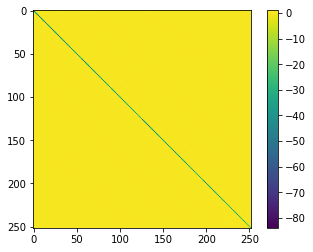

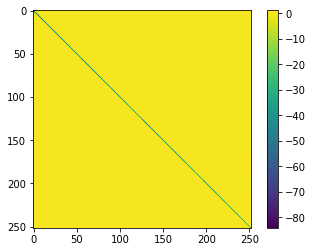

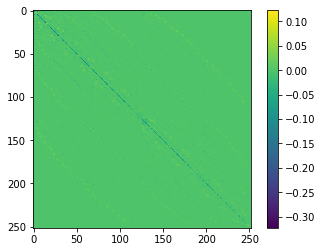

In [50]:


plt.imshow(h_quibit_tot.todense())
plt.colorbar()
plt.show()

plt.imshow(tot_hamiltonian.todense())
plt.colorbar()
plt.show()

plt.imshow(tot_hamiltonian.todense()-h_quibit_tot.todense())
plt.colorbar()
plt.show()



In [51]:
count=0
for i in range(delta_hamiltonian.shape[0]):
    if delta_hamiltonian[22,i]!=0:
        print(delta_hamiltonian_exact[22,i])
        print(delta_hamiltonian[22,i],'\n')
        count+=1

print(count)

0.008511828501623573
0.0013493950649064955 

-0.0006228008346903038
-0.009504771043181322 

-0.013433986968335697
0.0026238264195461284 

0.0008416272502759489
-0.0018214045835278098 

8.725191689153592e-05
0.0002241382158775264 

-0.0020732278326265016
-7.004119200147131e-05 

-0.00448721238239037
0.011645796569471576 

0.023607077651328655
-0.009603143631427393 

-0.011944755161071309
-0.0006436864779090285 

0.011024037044708314
0.015547216152854471 

0.0051077800303606135
-0.030857991658014863 

-0.0060963539071986605
-0.00107584603252426 

0.0014248559335204459
-0.002348673415389051 

-0.000735707351714715
0.0038254717967759165 

-0.0012626089397495609
-0.0036715091161277913 

-0.003150529909793441
0.016795910200459625 

0.0010452970329810887
0.0013604354273157508 

0.007308292929968797
0.02051869322087638 

-0.0005696054183359227
0.0018521527089367601 

-0.0020908864877783795
0.0006512406411458818 

0.0013454873995852432
-0.01768334651691277 

-0.00834480837588261
0.0198842760346

In [52]:
print(psifinal[:,0].conjugate().dot(psiqubit[:,0])*np.conjugate(psifinal[:,0].conjugate().dot(psiqubit[:,0])))

0.999692540778373


In [53]:
print((psiqubit[:,0].conjugate().dot(tot_hamiltonian.dot(psiqubit[:,0]))))

-85.34920415860873


Analysis with respect to the exact ground state

In [54]:
psiqubit_fermionic=QPC.particles2quasiparticles.T @ psiqubit[:,0]
psifinal_fermionic=QPC.particles2quasiparticles.T @ psifinal[:,0]
fidelity_exact_groundstate=psi0[:,0].conjugate().dot(psiqubit_fermionic)*np.conjugate(psi0[:,0].conjugate().dot(psiqubit_fermionic))
fidelity_exact_groundstate_2=psi0[:,0].conjugate().dot(psifinal_fermionic)*np.conjugate(psi0[:,0].conjugate().dot(psifinal_fermionic))
print(fidelity_exact_groundstate,fidelity_exact_groundstate_2)

0.9895787170358082 0.9898856318024586
